Iter 1: ||delta_alpha|| = 2.092903e-07
Iter 2: ||delta_alpha|| = 1.303207e-07
Iter 3: ||delta_alpha|| = 5.325227e-08
Iter 4: ||delta_alpha|| = 4.755594e-08
Iter 5: ||delta_alpha|| = 5.152607e-08
Iter 6: ||delta_alpha|| = 3.165747e-08
Iter 7: ||delta_alpha|| = 2.211185e-08
Iter 8: ||delta_alpha|| = 2.505401e-08
Iter 9: ||delta_alpha|| = 1.862164e-08
Iter 10: ||delta_alpha|| = 1.565473e-08
Iter 11: ||delta_alpha|| = 1.489630e-08
Iter 12: ||delta_alpha|| = 1.113549e-08
Iter 13: ||delta_alpha|| = 1.361016e-08
Iter 14: ||delta_alpha|| = 1.229644e-08
Iter 15: ||delta_alpha|| = 7.424171e-09
Iter 16: ||delta_alpha|| = 1.019410e-08
Iter 17: ||delta_alpha|| = 8.391807e-09
Iter 18: ||delta_alpha|| = 4.720733e-09
Iter 19: ||delta_alpha|| = 9.176210e-09
Iter 20: ||delta_alpha|| = 7.537119e-09
Iter 21: ||delta_alpha|| = 4.418169e-09
Iter 22: ||delta_alpha|| = 7.359845e-09
Iter 23: ||delta_alpha|| = 5.678464e-09
Iter 24: ||delta_alpha|| = 4.019169e-09
Iter 25: ||delta_alpha|| = 5.536599e-09
Iter 26: 

Text(0, 0.5, 'PC2')

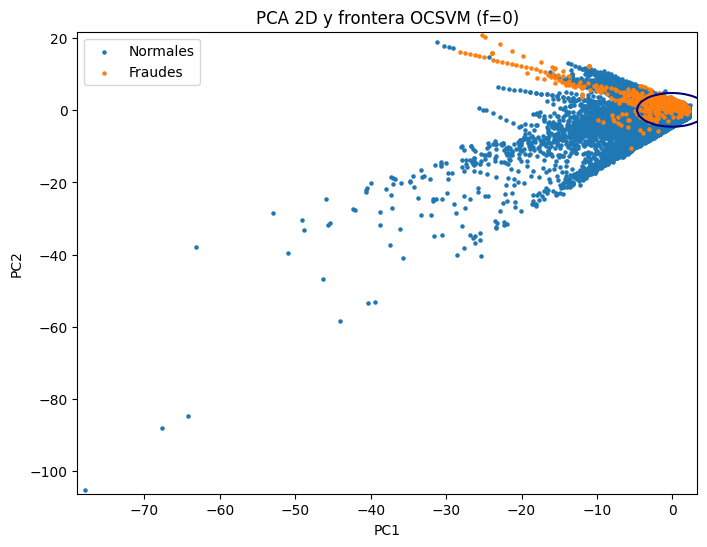

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class OCSVM:
    def __init__(self, nu=0.1, gamma=0.0098, kernel='rbf',
                 lr=0.01, max_iter=50000, tol=1e-9,
                 beta1=0.9, beta2=0.999, eps=1e-8,
                 n_subsample=8700, random_state=42):
        self.nu = nu
        self.gamma = gamma
        self.kernel = kernel
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.n_sub = n_subsample
        self.random_state = random_state

    def _rbf_kernel(self, X, Y=None):
        if Y is None:
            Y = X
        X2 = np.sum(X*X, axis=1)[:,None]
        Y2 = np.sum(Y*Y, axis=1)[None,:]
        dist2 = X2 + Y2 - 2 * X.dot(Y.T)
        return np.exp(-self.gamma * dist2)

    def _project_alphas(self, alpha, C, iters=20):
        for _ in range(iters):
            alpha = alpha - (np.sum(alpha) - 1.0) / alpha.size
            alpha = np.clip(alpha, 0.0, C)
        return alpha

    def fit(self, X):
        np.random.seed(self.random_state)
        n, d = X.shape
        self.X_mean = X.mean(axis=0)
        self.X_std  = X.std(axis=0) + 1e-12
        Xn = (X - self.X_mean) / self.X_std
        if n > self.n_sub:
            idx = np.random.choice(n, self.n_sub, replace=False)
            Xn = Xn[idx]
        self.X_train = Xn
        n_train = Xn.shape[0]
        C = 1.0 / (self.nu * n_train)
        if self.gamma is None:
            self.gamma = 1.0 / d
        K = self._rbf_kernel(Xn)
        alpha = np.ones(n_train) / n_train
        m = np.zeros(n_train)
        v = np.zeros(n_train)
        for t in range(1, self.max_iter+1):
            grad = K.dot(alpha)
            m = self.beta1 * m + (1-self.beta1) * grad
            v = self.beta2 * v + (1-self.beta2) * (grad*grad)
            m_hat = m / (1 - self.beta1**t)
            v_hat = v / (1 - self.beta2**t)
            alpha_prev = alpha.copy()
            alpha = alpha - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
            alpha = self._project_alphas(alpha, C)
            delta = np.linalg.norm(alpha - alpha_prev)
            print(f"Iter {t}: ||delta_alpha|| = {delta:.6e}")
            if delta < self.tol/18:
                print(f"CONVERGIÓ in {t} ITER.")
                break
        self.alpha = alpha
        sv = np.where((alpha>1e-8) & (alpha<C-1e-8))[0]
        f_sv = K[:,sv].T.dot(alpha)
        self.rho = f_sv.mean()
        print(f"Final rho: {self.rho:.6f}")
        print(f"TOT vectors: {np.sum(alpha > 1e-8)}")
        print(f"Bounded support vectors: {np.sum((alpha > 1e-8) & (alpha < C - 1e-8))}")
        return self

    def decision_function(self, X):
        Xn = (X - self.X_mean) / self.X_std
        Kxt = self._rbf_kernel(self.X_train, Xn)
        f = self.alpha.dot(Kxt) - self.rho
        return f

    def predict(self, X):
        f = self.decision_function(X)
        return (f < 0).astype(int)


df_carac = pd.read_csv('creditcard_anomalies.csv')
df_lbl   = pd.read_csv('creditcard_labels.csv')
if len(df_carac) != len(df_lbl):
    raise ValueError('Mismatch en filas.')
df_carac['Class'] = df_lbl['Class'].values
df = df_carac
normales = df.loc[df['Class'] == 0, df.columns.difference(['Class'])]
test_all = df.copy()
y_true   = test_all['Class'].values
X_all    = test_all.drop(columns=['Class']).values

ocsvm = OCSVM(nu=0.0149, lr=0.0734, max_iter=10000, n_subsample=1350)
ocsvm.fit(normales.values)
y_pred = ocsvm.predict(X_all)

def confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    return np.array([[TN, FP],[FN, TP]])

def precision_recall_f1(cm):
    TN,FP, FN,TP = cm.ravel()
    prec = TP/(TP+FP+1e-12)
    rec  = TP/(TP+FN+1e-12)
    f1   = 2*prec*rec/(prec+rec+1e-12)
    return prec, rec, f1

cm   = confusion_matrix(y_true, y_pred)
prec, rec, f1 = precision_recall_f1(cm)
scores = -ocsvm.decision_function(X_all)

print("Matriz de confusi\u00f3n:\n", cm)
print(f"Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

X = np.vstack([ocsvm.X_train, X_all])
X_centered = X - X.mean(axis=0)
C = np.cov(X_centered.T)
eigvals, eigvecs = np.linalg.eigh(C)
idx = np.argsort(eigvals)[::-1][:2]
P = eigvecs[:, idx]
proj_train = ocsvm.X_train.dot(P)
proj_all   = X_all.dot(P)
x_min, x_max = proj_all[:,0].min()-1, proj_all[:,0].max()+1
y_min, y_max = proj_all[:,1].min()-1, proj_all[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
mean_orig = ocsvm.X_mean
std_orig  = ocsvm.X_std
orig = (grid.dot(P.T) * std_orig) + mean_orig
f_grid = ocsvm.decision_function(orig).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contour(xx, yy, f_grid, levels=[0], cmap='jet')
plt.scatter(proj_all[y_true==0,0], proj_all[y_true==0,1], s=5, label='Normales')
plt.scatter(proj_all[y_true==1,0], proj_all[y_true==1,1], s=5, label='Fraudes')
plt.legend()
plt.title("PCA 2D y frontera OCSVM (f=0)")
plt.xlabel("PC1"); plt.ylabel("PC2")
# plt.show()


In [1]:
pip install joblib

  Using cached joblib-1.5.0-py3-none-any.whl.metadata (5.6 kB)
Using cached joblib-1.5.0-py3-none-any.whl (307 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


holaaaaaaaaa